In [16]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

# this is for making Graphviz work (plot_model needs GraphViz)
from IPython.display import HTML
from keras.utils.vis_utils import plot_model, model_to_dot
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

os.sys.path.append('..')
from utils.model_utils import serialize_model
from sklearn.preprocessing import MinMaxScaler

In [17]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
def split_sequences_multivariate(sequences, n_steps=32):
    
    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    #n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    #sequences = np.concatenate([X_train, X_train[:,0].reshape(-1,1)],axis=1)
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    #print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

# split a multivariate sequence into samples
def multi_step_output(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def plot_distribution_error(model, train_X, test_X, train_y, test_y):
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle('Distributions of Prediction and True Values', y=1.02, fontsize=13.5)
    sns.distplot(a=train_predictions.flatten(), ax=ax1, label='Prediction')
    sns.distplot(a=train_y.flatten(), ax=ax1, label= 'True')
    sns.distplot(a=test_predictions.flatten(), ax=ax2, label='Prediction')
    sns.distplot(a=test_y.flatten(), ax=ax2, label='True')
    plt.legend()
    plt.tight_layout()

def get_mae_overall(model, train_X, test_X, train_y, test_y):
    
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    
    MAE_train = abs(train_predictions - train_y).mean()
    MAE_test = abs(test_predictions - test_y).mean()
    if train_y.shape[1] == 3:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1))
    else:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1,2))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1,2))
    
    return MAE_train, MAE_test, mae_overall_train, mae_overall_test

def plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test):
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,4))
    fig.suptitle('MAE Overall', y=1.02, fontsize=13.5)
    
    ax1.plot(mae_overall_train, label='MAE Train')
    ax1.set_title('MAE Train={}'.format(MAE_train))
    ax2.plot(mae_overall_test, label='MAE Test', color='teal')
    ax2.set_title('MAE Test={}'.format(MAE_test))
    fig.legend(loc='upper right')
    plt.tight_layout()
    
def plot_predictions(model, train_X, test_X, train_y, test_y):
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    
    data_final = dict(train_pred=train_predictions, train_true=train_y,
                      test_pred=test_predictions, test_true=test_y)

    # Number of time steps in the future, as increases the accuracy decreases
    ith_timestep = 7

    for lb in ['train', 'test']:   
        fig, axx = plt.subplots(3,1,figsize=(18,9))
        for i, x_lbl, clr,axi in zip([0, 1, 2], ['Temperature', 'VMPPT','VPanel'], ['salmon', 'teal','darkblue'], axx):
            axi.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='-', color='r', label='pred '+x_lbl)
            axi.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
            axi.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
        fig.suptitle('({}): {}th time step in all samples'.format(lb, ith_timestep), y=1.02,fontsize=15)
        plt.tight_layout()

Lenght of Data 14688
Lenght of Train 11750


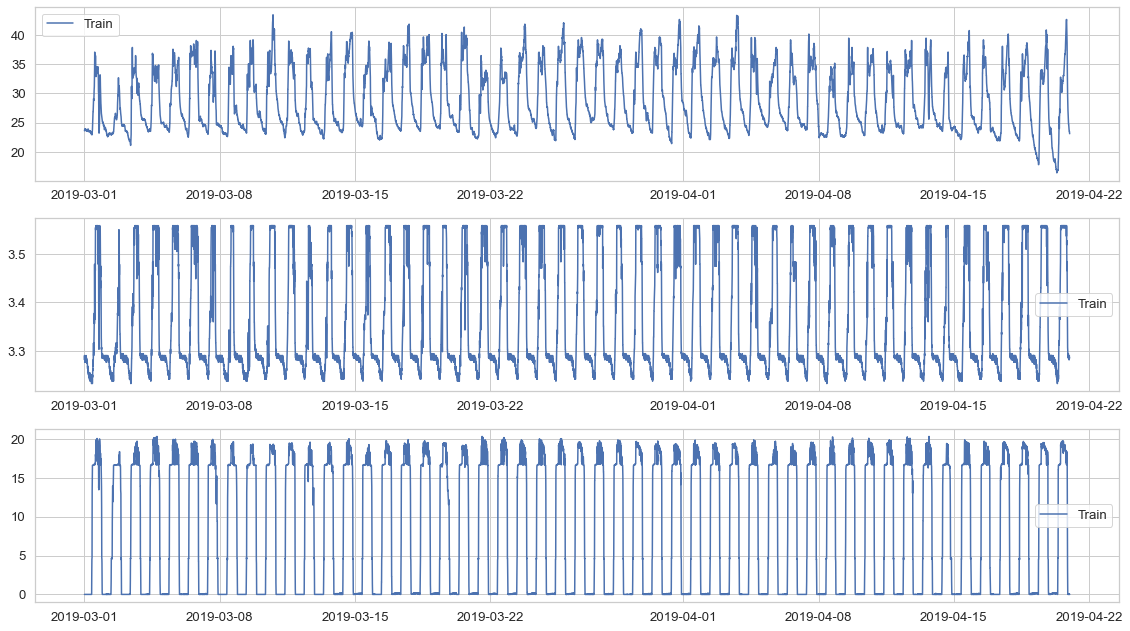

In [15]:
# Block to load file depending if you are in Colab or in Jupyter
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !wget --no-check-certificate \
        https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0 \
        -O /tmp/Features.csv
        
    data = pd.read_csv('/tmp/Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')
else:
    path_of_file = '../Data/single_feature.csv'
    data = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')

# The data is higly irregular so let's resample it to 10 min and take the mean
resampled = data.resample('5Min').mean()
resampled = resampled.fillna(resampled.bfill())
# Now let's take only a slice of it

init_date = '2019-03'
train_end_date = '2019-10-25'
end_date = '2019-04-20'
#Separate Train and test
train_data = resampled[init_date:end_date]

fig, axx = plt.subplots(3,1, figsize=(16,9))
for ii, ax in zip(train_data.columns, axx):
    ax.plot(train_data[ii], label='Train')
    ax.legend()
plt.tight_layout()

train_ratio = 0.8
train_len = int(train_ratio*len(train_data))
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(train_data)
print('Lenght of Data {}'.format(len(normalized_train)))
print('Lenght of Train {}'.format(train_len))

## Baseline LSTM

(11622, 128, 3) (11622, 3)
(2810, 128, 3) (2810, 3)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128, 128)          67584     
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 199,555
Trainable params: 199,555
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
146/146 [==============================] - 86s 592ms/step - loss: 0.0277 - mae: 0.0889 - val_loss: 0.0053 - val_mae: 0.0466
Epoch 2/100
146/146 [==============================] - 82s 559ms/step - loss: 0.0080 - mae: 0.0584 - val_loss: 0.0047 - val_mae: 0.0420
Epoch 3/100
146/146 [==============================] -

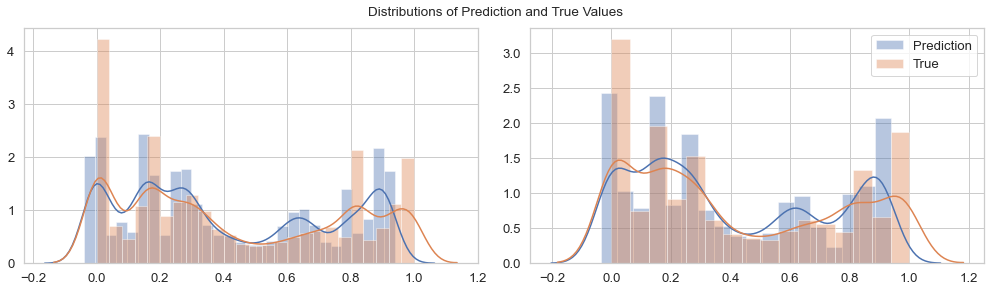

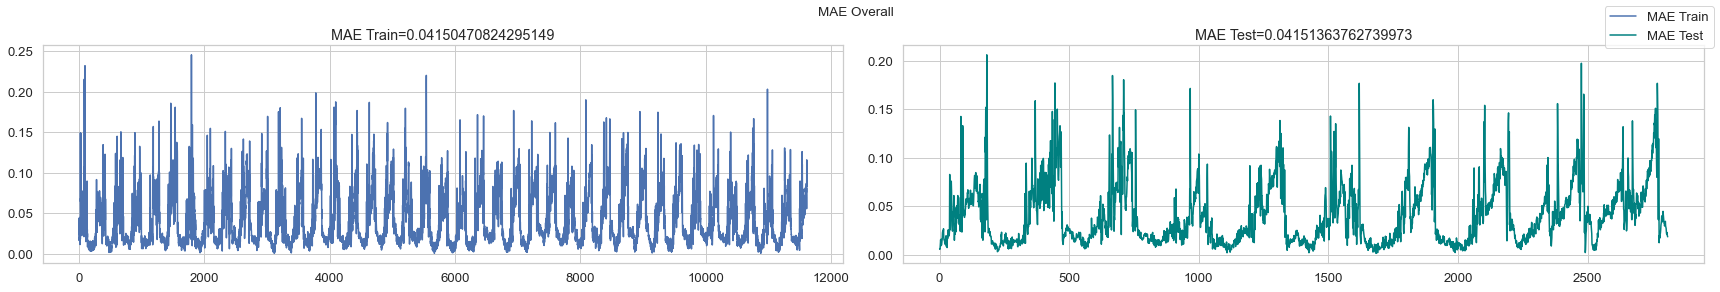

In [29]:
from utils.model_utils import split_sequences_multivariate

n_timesteps = 128
n_features = normalized_train.shape[-1]

train_X_lstm, train_y_lstm = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps)
test_X_lstm, test_y_lstm = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps)
#print('Training Shapes. X{}, y{} '.format(train_X_lstm.shape, train_y_lstm.shape))
#print('Testing Shapes. X{}, y{} '.format(test_X_lstm.shape, test_y_lstm.shape))

model_LSTM = tf.keras.models.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(units=128, input_shape=(n_timesteps, n_features),
                                    return_sequences=True, dropout=0.2))
model_LSTM.add(tf.keras.layers.LSTM(units=128, input_shape=(n_timesteps, n_features),
                                    return_sequences=False, dropout=0.2))
#model_LSTM.add(tf.keras.layers.BatchNormalization())
model_LSTM.add(tf.keras.layers.Dense(n_features))
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
model_LSTM.summary()
#tf.keras.utils.plot_model(model_LSTM, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=80)

epochs = 100
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_LSTM.fit(train_X_lstm, train_y_lstm,
                         validation_split=0.2, 
                         epochs=epochs, verbose=1,
                         callbacks=[early_stop], 
                         batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])

plot_distribution_error(model_LSTM, train_X_lstm, test_X_lstm, train_y_lstm, test_y_lstm)

MAE_train, MAE_test, mae_overall_train, mae_overall_test = \
get_mae_overall(model_LSTM, train_X_lstm, test_X_lstm, train_y_lstm, test_y_lstm)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test)

## Seq2Seq

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 3)]     0                                            
__________________________________________________________________________________________________
lstm_14 (LSTM)                  [(None, 128), (None, 67584       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 16, 128)      0           lstm_14[0][0]                    
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 16, 128)      131584      repeat_vector[0][0]              
                                                                 lstm_14[0][0]         

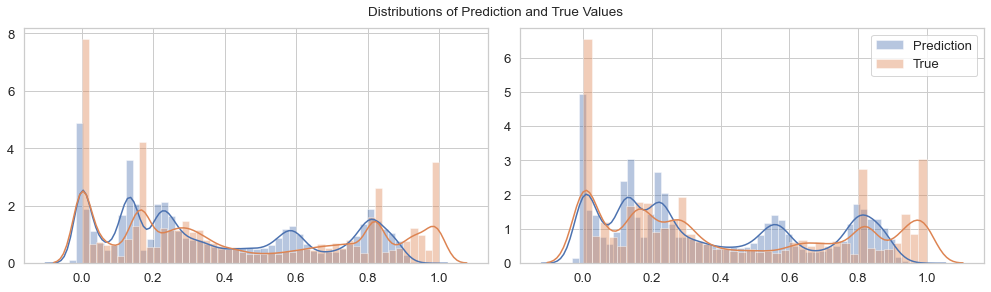

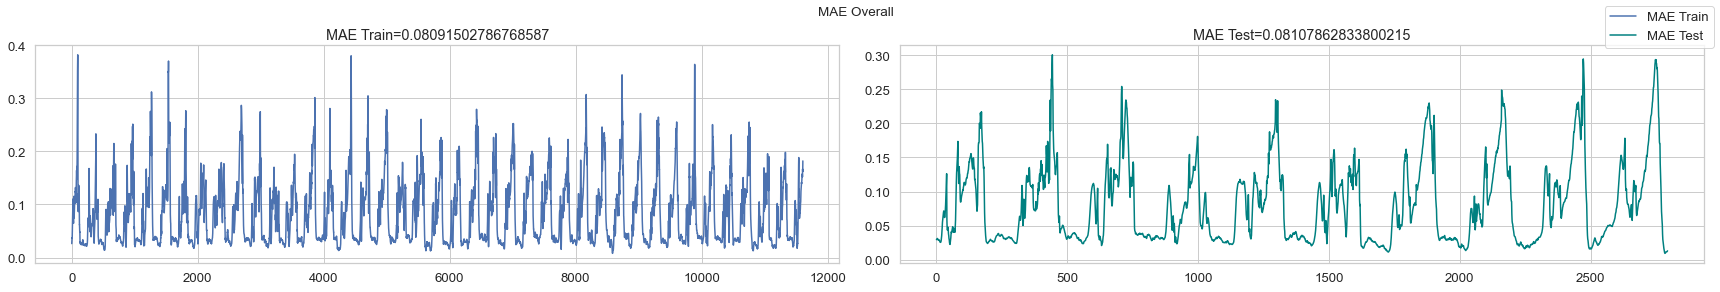

In [30]:
n_timesteps_in = 128
n_timesteps_out = 16
n_samples = 3
n_hidden = 128

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
input_train = Input(shape=(train_X.shape[1], train_X.shape[2]))
output_train = Input(shape=(train_y.shape[1], train_y.shape[2]))

encoder_last_h1, encoder_last_h2, encoder_last_c = \
tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=0.2,
                     return_sequences=False,
                     return_state=True)(input_train)

# Batch normalisation is added because we want to avoid gradient
# explosion caused by the activation function ELU in the encoder.
#encoder_last_h1 = BatchNormalization(momentum=0.9)(encoder_last_h1)
#encoder_last_c = BatchNormalization(momentum=0.9)(encoder_last_c)

# Create copies of las hidden state
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
# nitial_state: List of initial state tensors to be passed to the first call of the cell 
#(optional, defaults to None which causes creation of zero-filled initial state tensors).
# In this case initial state is the output from encoder
decoder = tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=0.2,
                               return_state=False,
                               return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
model = Model(inputs=input_train, outputs=out)
optimizer = tf.keras.optimizers.Adam(lr=0.001, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
model.summary()

epochs = 100
batch_size = 64
early_stop = EarlyStopping(monitor='val_mae', patience=5)

history = model.fit(train_X, train_y,
                    validation_split=0.2, 
                    epochs=epochs, verbose=1,
                    callbacks=[early_stop], 
                    batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])

plot_distribution_error(model, train_X, test_X, train_y, test_y)

MAE_train, MAE_test, mae_overall_train, mae_overall_test = \
get_mae_overall(model, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 3)]     0                                            
__________________________________________________________________________________________________
lstm_23 (LSTM)                  [(None, 128, 128), ( 67584       input_9[0][0]                    
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 16, 128)      0           lstm_23[0][1]                    
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 16, 128)      131584      repeat_vector_4[0][0]            
                                                                 lstm_23[0][1]         

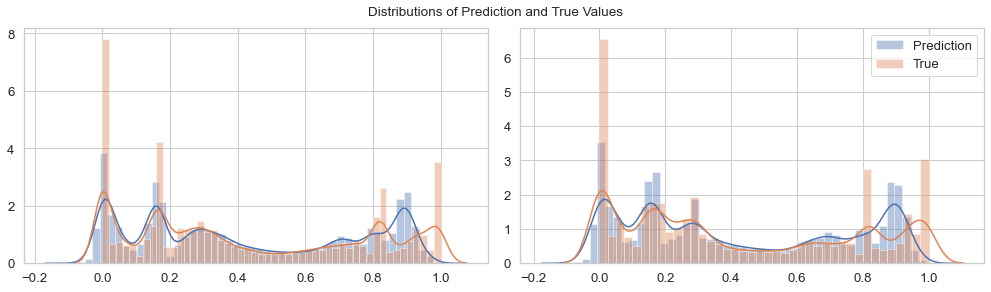

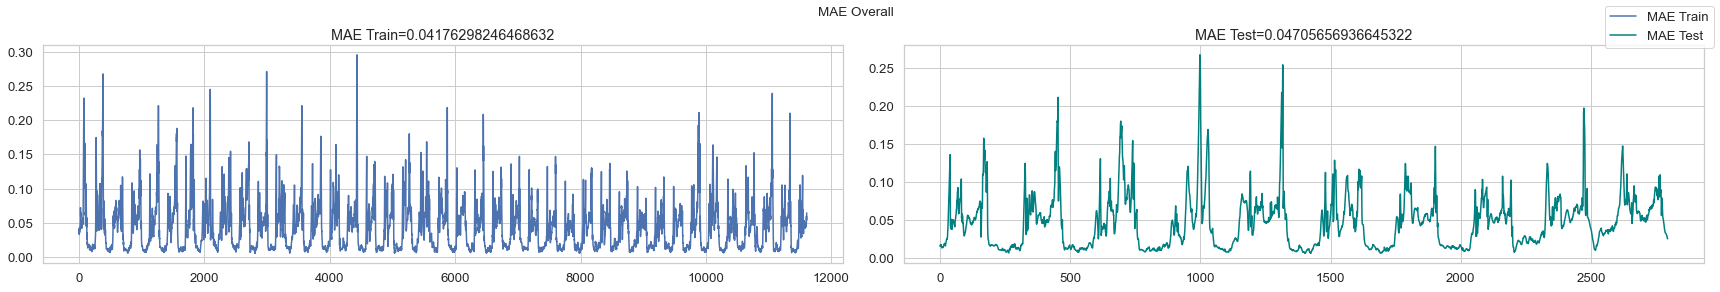

In [36]:
n_timesteps_in = 128
n_timesteps_out = 16
n_samples = 3
n_hidden = 128

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

input_train = Input(shape=(train_X.shape[1], train_X.shape[2]))
output_train = Input(shape=(train_y.shape[1], train_y.shape[2]))

encoder_stack_h, encoder_last_h, encoder_last_c = \
tf.keras.layers.LSTM(n_hidden, activation='tanh', 
                     return_sequences=True,
                     return_state=True)(input_train)

#encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
#encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# Repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.
decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)

decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='tanh', return_state=False,
                                       return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

# Alignment Score is Dot Product in Luong Attention
attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = tf.keras.layers.Activation('softmax', name='Softmax')(attention)
context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
#context = BatchNormalization(momentum=0.6)(context)
# Now we concat the context vector and stacked hidden states of decoder, 
# and use it as input to the last dense layer.
decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)

model = tf.keras.models.Model(inputs=input_train, outputs=out)
optimizer = tf.keras.optimizers.Adam(lr=0.001, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
model.summary()

epochs = 100
batch_size = 64
early_stop = EarlyStopping(monitor='val_mae', patience=5)

history = model.fit(train_X, train_y,
                    validation_split=0.2, 
                    epochs=epochs, verbose=1,
                    callbacks=[early_stop], 
                    batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])

plot_distribution_error(model, train_X, test_X, train_y, test_y)

MAE_train, MAE_test, mae_overall_train, mae_overall_test = \
get_mae_overall(model, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test)

In [ ]:
n_timesteps_in = 128
n_timesteps_out = 8
n_samples = 3
n_hidden = 128

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

input_train = Input(shape=(train_X.shape[1], train_X.shape[2]))
output_train = Input(shape=(train_y.shape[1], train_y.shape[2]))

encoder_stack_h, encoder_last_h, encoder_last_c = \
tf.keras.layers.LSTM(n_hidden, activation='tanh', 
                     return_sequences=True,
                     return_state=True)(input_train)

#encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
#encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# Repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.
decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)

decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='tanh', return_state=False,
                                       return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

# Alignment Score is Dot Product in Luong Attention
attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = tf.keras.layers.Activation('softmax', name='Softmax')(attention)
context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
#context = BatchNormalization(momentum=0.6)(context)
# Now we concat the context vector and stacked hidden states of decoder, 
# and use it as input to the last dense layer.
decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)

model = tf.keras.models.Model(inputs=input_train, outputs=out)
optimizer = tf.keras.optimizers.Adam(lr=0.001, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
model.summary()

epochs = 100
batch_size = 256
early_stop = EarlyStopping(monitor='val_mae', patience=5)

history = model.fit(train_X, train_y,
                    validation_split=0.2, 
                    epochs=epochs, verbose=1,
                    callbacks=[early_stop], 
                    batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])

plot_distribution_error(model, train_X, test_X, train_y, test_y)

MAE_train, MAE_test, mae_overall_train, mae_overall_test = \
get_mae_overall(model, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test)